# PIB Filtering and Trend-Cycle Decomposition
---

This notebook scans the ../data/raw/ directory for the **latest available GDP series** from IBGE (series can be downloaded using IBGE.ipynb notebook).

It automatically detects CSV files with filenames following the standard naming pattern, and for each unique series (identified by table and variable), it keeps only the most recent file.

These files are matched with IBGE metadata to present the user with an intuitive interface to select:

- Real or Nominal GDP  
- Seasonally Adjusted or Non-Adjusted  
- Quarterly or Annual Frequency  

Once a series is selected, the notebook loads and processes the data. The following transformations and filters are applied:

- **Natural Log** — computed using **NumPy**
- **First Difference** — computed using **pandas**
- **Percentage Change** — computed using **pandas**
- **Hodrick-Prescott Filter** — using **statsmodels**
- **Baxter-King Filter** — using **statsmodels**
- **Christiano-Fitzgerald Filter** — using **statsmodels**

All of these operations are implemented using well-established, trusted Python libraries for time series and econometric analysis:

Finally, the notebook provides an interactive plotting interface so you can visually explore trends, cycles, and transformations of the GDP series with ease.

This environment is ideal for filtering, comparing smoothing methods, and preparing data for macroeconomic analysis and visualization.


## Notebook Setup and Dependencies Loading
---

Run the cell below in order to load dependencies, metadata, and start the logging session.

In [25]:
# Importing external libraries and functions
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import ipywidgets as widgets
import matplotlib.pyplot as plt

from datetime import datetime
from IPython.display import display, clear_output

# Add the 'src' folder to the Python path so project-specific modules can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# Import project-specific functions
from logger import start_logger
from ibge import load_ibge_series_metadata
from utils import compute_file_hash
from ui import file_explorer, raw_cleanup_widget, plot_columns_selector

# Enable automatic reloading of modules when their source code changes
%reload_ext autoreload
%autoreload 2

# Define Session ID
session_type = "Filtering"
session_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

# Setup Logging
log_file_name = f"../logs/{session_type}_{session_ID}.log"
logger_name = "root"
logger = start_logger(logger_name, log_file_name)

raw_cleanup_widget()

2025-04-22 09:39:12,693 - INFO - Logger started. File path: ../logs/Filtering_20250422_093912.log


## Select GDP data from available series
---

In [26]:
# Load metadata
df_ibge_series_metadata = load_ibge_series_metadata()
GDP_file_explorer_refs = file_explorer(df_ibge_series_metadata )

2025-04-22 09:39:14,589 - INFO - Loaded IBGE Metadata from file: ../data/metadata/ibge_series.json


## Filter data
---

In [27]:
# Function to get data from Widget selection
def get_data(selected_filename): 
    # Load the DataFrame
    df = pd.read_csv(selected_filename)

    # Convert columns if present
    if "data" in df.columns:
        df["data"] = pd.to_datetime(df["data"], errors="coerce")

    if "valor" in df.columns:
        df["valor"] = pd.to_numeric(df["valor"], errors="coerce")
    return df

# Get data acoridng to Widget Selection
df = get_data(GDP_file_explorer_refs["get_selected_file"]())
df.rename(columns={"valor": "gdp"}, inplace=True)

# Create log of gdp
df["gdp"] = df["gdp"]
df["log_gdp"] = df["gdp"].apply(lambda x: np.log(x) if x > 0 else np.nan)

#--------------------------
# Detrending

# Independent variable (x): time
x = df['data'].apply(lambda d: d.toordinal())
x = sm.add_constant(x)  # Adds intercept term

# Dependent variable (y): value
y = df['log_gdp']

# Fit model
model = sm.OLS(y, x).fit()

# Get all coefficients
coefficients = model.params

# Add predicted values (trend) to the DataFrame
df['OLS_trend'] = model.predict(x)

# Calculate the cycle (residual)
df['OLS_cycle'] = df['log_gdp'] - df['OLS_trend']

# Print summary
#print(model.summary())
#Trend = (coefficients['const'] + coefficients['data']*x['data'])
#Cycle = df['log_gdp'] - (coefficients['const'] + coefficients['data']*x['data'])

#--------------------------
# Create first difference of log_gdp
df["fdiff_cycle"] = df["log_gdp"].diff() - df["log_gdp"].diff().mean()
df["fdiff_trend"] = df["log_gdp"] - df["fdiff_cycle"]

#--------------------------
# HP Filter
df["hp_cycle"], df["hp_trend"]  = sm.tsa.filters.hpfilter(df["log_gdp"], 1600)

#--------------------------
# BK Filter
df["bk_cycle"] = sm.tsa.filters.bkfilter(df["log_gdp"], 6, 32, 12)
df["bk_trend"] = df["log_gdp"] - df["bk_cycle"] 

#--------------------------
# CF Filter
df["ck_cycle"], df["ck_trend"]  = sm.tsa.filters.cffilter(df["log_gdp"], 6,32,False)



### Plot filtered GDP data
---

In [28]:
# Create the widget to select columns (except 'data')
column_selector = widgets.SelectMultiple(
    options=[col for col in df.columns if col != "data"],
    description="Y Columns:",
    layout=widgets.Layout(width="400px", height="200px")
)

# Output area for the plot
plot_output = widgets.Output()

# Function to update the plot
def update_plot(change):
    with plot_output:
        clear_output()
        selected = list(column_selector.value)

        if not selected:
            print("Select at least one column to plot.")
            return

        # Plot
        sns.set_theme()
        sns.set_context("notebook")
        plt.figure(figsize=(12, 6))

        for col in selected:
            plt.plot(df["data"], df[col], label=col)

        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Selected Columns Over Time")
        plt.legend()
        sns.despine()
        plt.tight_layout()
        plt.show()

# Connect widget to function
column_selector.observe(update_plot, names="value")

# Display UI
display(widgets.HTML("<b>Select columns to plot (X axis is always 'data'):</b> Use CTRL or CMD to select multiple rows"))
display(
    widgets.HBox([
        column_selector,
        plot_output
    ])
)

# Initial plot
update_plot({"new": column_selector.value})


HTML(value="<b>Select columns to plot (X axis is always 'data'):</b> Use CTRL or CMD to select multiple rows")

## Select Inflation Data
---

In [29]:
# Load metadata
IPCA_file_explorer_refs = file_explorer(df_ibge_series_metadata )

In [42]:
#--------------------------------------------
# Transform inflation data from motnhly to quarterly
#--------------------------------------------

# Load selected IPCA file from the file explorer widget
dfa = get_data(IPCA_file_explorer_refs["get_selected_file"]())

# Convert monthly percent change to decimal (for compounding)
dfa["decimal"] = 1 + dfa["valor"] / 100

# Set date as index and resample to quarterly using compounded product
dfa.set_index("data", inplace=True)
dfa = dfa.resample("QE").prod()  # 'QE' = quarter end

# Shift quarterly dates from end-of-quarter to start-of-quarter
dfa = dfa.reset_index()[["data", "decimal"]]
dfa["data"] = dfa["data"] + pd.Timedelta(days=1)
dfa["decimal"] = dfa["decimal"].shift(-1)
dfa = dfa[:-1]

# Convert decimal back to percent change and drop intermediate column
dfa["pi"] = (dfa["decimal"] - 1)
dfa = dfa[["data", "pi"]]

In [33]:
## TEST ROUTINE 
## Manually calculates quarterly inflation. 

dfb = get_data(IPCA_file_explorer_refs["get_selected_file"]())[-15:]

a_date ='2024-01-01'
b_date ='2024-02-01'
c_date ='2024-03-01'

a=dfb[dfb["data"]==a_date]['valor'].values[0]
b=dfb[dfb["data"]==b_date]['valor'].values[0]
c=dfb[dfb["data"]==c_date]['valor'].values[0]

print(f"{a+b+c}")
print(f"{((1+a/100)*(1+b/100)*(1+c/100)-1)*100}")

1.24
1.2437666239999867


In [11]:
def first_difference_filter(df, column):
    """
    Applies a first difference filter to a column in a DataFrame.
    
    Returns:
    - cycle: de-meaned first difference
    - trend: original series minus cycle
    """
    diff = df[column].diff()
    cycle = diff - diff.mean()
    trend = df[column] - cycle
    return cycle, trend

In [43]:
dfa['pi_fdiff'] = dfa['pi'].diff()

#dfa['pi_fdiff_cycle'], dfa['pi_fdiff_trend'] = first_difference_filter(dfa,'pi')

#dfa["pi_log"] = dfa["pi"].apply(lambda x: np.log(x) if x > 0 else np.nan)
#dfa['pi_log_fdiff_cycle'], dfa['pi_log_fdiff_trend'] = first_difference_filter(dfa,'pi')

#dfa['pi_level'] = (1 + dfa['pi']).cumprod()
#dfa['pi_level_fdiff_cycle'], dfa['pi_level_fdiff_trend'] = first_difference_filter(dfa,'pi_level')

#dfa["pi_level_log"] = dfa["pi_level"].apply(lambda x: np.log(x) if x > 0 else np.nan)
#dfa['pi_level_log_fdiff_cycle'], dfa['pi_level_log_fdiff_trend'] = first_difference_filter(dfa,'pi_level_log')

In [44]:
dfc = df.merge(dfa,on='data')

In [50]:
dfc.columns = [
    'data',                  # Quarterly date
    'gdp_raw',               # Raw GDP
    'gdp_log',               # Log of GDP
    'gdp_OLS_trend',         # OLS trend of GDP
    'gdp_OLS_cycle',         # OLS cycle of GDP
    'gdp_fdiff_cycle',       # First-diff cycle of GDP
    'gdp_fdiff_trend',       # First-diff trend of GDP
    'gdp_HP_cycle',          # HP filter cycle of GDP
    'gdp_HP_trend',          # HP filter trend of GDP
    'gdp_BK_cycle',          # Band-pass (Baxter-King) cycle
    'gdp_BK_trend',          # Band-pass trend (if available)
    'gdp_CK_cycle',          # Christiano-Fitzgerald (CK) cycle
    'gdp_CK_trend',          # CK trend
    'inflation',             # Inflation (level)
    'inflation_fdiff'        # First difference of inflation
]

In [51]:
# Create the widget to select columns (except 'data')
column_selector = widgets.SelectMultiple(
    options=[col for col in dfc.columns if col != "data"],
    description="Y Columns:",
    layout=widgets.Layout(width="400px", height="200px")
)

# Output area for the plot
plot_output = widgets.Output()

# Function to update the plot
def update_plot(change):
    with plot_output:
        clear_output()
        selected = list(column_selector.value)

        if not selected:
            print("Select at least one column to plot.")
            return

        # Plot
        sns.set_theme()
        sns.set_context("notebook")
        plt.figure(figsize=(12, 6))

        for col in selected:
            plt.plot(dfc["data"], dfc[col], label=col)

        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Selected Columns Over Time")
        plt.legend()
        sns.despine()
        plt.tight_layout()
        plt.show()

# Connect widget to function
column_selector.observe(update_plot, names="value")

# Display UI
display(widgets.HTML("<b>Select columns to plot (X axis is always 'data'):</b> Use CTRL or CMD to select multiple rows"))
display(
    widgets.HBox([
        column_selector,
        plot_output
    ])
)

# Initial plot
update_plot({"new": column_selector.value})

HTML(value="<b>Select columns to plot (X axis is always 'data'):</b> Use CTRL or CMD to select multiple rows")

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from IPython.display import display, clear_output

def correlation_matrix_widget(df):
    # Multi-select widget for column selection
    column_selector = widgets.SelectMultiple(
        options=df.columns,
        description='Select columns:',
        rows=10,
        layout=widgets.Layout(width='50%'),
        style={'description_width': 'initial'}
    )

    # Button widget to trigger plot
    plot_button = widgets.Button(description="Plot Correlation Matrix")

    # Output area for displaying plot
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            selected = list(column_selector.value)
            if len(selected) < 2:
                print("Please select at least two columns.")
                return

            # Compute correlation matrix
            corr = df[selected].corr()

            # Create mask for the upper triangle
            mask = np.triu(np.ones_like(corr, dtype=bool))

            # Plot the lower triangle
            plt.figure(figsize=(10,8))
            sns.heatmap(
                corr,
                mask=mask,
                annot=True,
                cmap='coolwarm',
                vmin=-1, vmax=1,
                linewidths=0.5,
                square=True,
                annot_kws={"size": 10},  # Smaller font size for annotations
            )
            plt.title("Lower Triangle Correlation Matrix")
            plt.xticks(rotation=45, fontsize=10, ha='center')
            plt.yticks(rotation=0, fontsize=10)
            plt.tight_layout()
            plt.show()

    plot_button.on_click(on_button_click)

    # Display all widgets together
    display(widgets.VBox([column_selector, plot_button, output]))


In [ ]:
correlation_matrix_widget(dfc)

In [129]:
dfc['OLS_cycle'].corr(dfc['pi_cycle'])

np.float64(0.020900887967765062)

In [ ]:
from statsmodels.tsa.stattools import acovf

acovf(dfc['OLS_cycle'], fft=False, demean=True, adjusted=False)

np.float64(0.004217049002242537)

In [54]:
import pandas as pd
import numpy as np
from scipy.stats import bartlett, levene
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acovf

def series_diagnostics_report(series, lags=10):
    """
    Print a diagnostic report on a time series, evaluating:
    - Mean
    - Constant variance (homoskedasticity)
    - Autocovariance
    - ARCH effect (volatility clustering)

    Parameters:
        series (pd.Series): The time series to analyze.
        lags (int): Number of lags to compute autocovariances.
    """
    series = series.dropna()
    n = len(series)

    print("=== Time Series Diagnostics Report ===\n")

    # Mean
    mean_val = series.mean()
    print(f"-----------")
    print(f"Mean: {mean_val}")

    # ARCH Test (for heteroskedasticity)
    arch_test_stat, arch_pvalue, _, fpval = het_arch(series, nlags=lags)
    print(f"-----------")
    print(f"Tests for Homoscedasticity")   
    print(f"- ARCH Test")
    print(f"Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH)")
    print(f"The null hypothesis of the ARCH test is that there is no ARCH effect present, meaning the variance of the error terms is constant over time (homoscedasticity)")
    print(f"ARCH Test (Lags={lags}): p-value = {arch_pvalue:.4f}, fp-value = {fpval:.4f}")
    if arch_pvalue < 0.05:
        print(f"❗ There is sufficient statistical evidence to reject the null hypothesis at the 5% significance level.")
    else:
        print(f"✅ There is NO sufficient statistical evidence to reject the null hypothesis at the 5% significance level.")
          
    # Bartlett and Levene tests (first vs. second half variance)
    first_half = series.iloc[:n//2]
    second_half = series.iloc[n//2:]

    bartlett_p = bartlett(first_half, second_half).pvalue
    levene_p = levene(first_half, second_half).pvalue
    print(f"-----------")
    print("- Bartlett Test: Comparing Variance Between First and Second Half of the Series")
    print(f"The Bartlett test tests the null hypothesis that all input samples are from populations with equal variances.")
    print(f"Bartlett Test p-value: {bartlett_p:.4f}")
    if bartlett_p < 0.05:
        print(f"❗ There is sufficient statistical evidence to reject the null hypothesis at the 5% significance level.")
    else:
        print(f"✅ There is NO sufficient statistical evidence to reject the null hypothesis at the 5% significance level.")
  
    print("- Levene Test: Comparing Variance Between First and Second Half of the Series")
    print(f"The Levene test tests the null hypothesis that all input samples are from populations with equal variances.")
    print(f"Levene Test p-value: {levene_p:.4f}")
    if levene_p < 0.05:
        print(f"❗ There is sufficient statistical evidence to reject the null hypothesis at the 5% significance level.")
    else:
        print(f"✅ There is NO sufficient statistical evidence to reject the null hypothesis at the 5% significance level.")

    # Autocovariances
    acovs = acovf(series, fft=False)
    print(f"-----------")
    print(f"Autocovariances")
    print(f"    Min:  {acovs.min():.4f}")
    print(f"    Max:  {acovs.max():.4f}")
    print(f"    Mean: {acovs.mean():.4f}")



In [55]:
import pandas as pd
import numpy as np
from scipy.stats import bartlett, levene
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acovf

def series_diagnostics_report(series, lags=10):
    """
    Print a diagnostic report on a time series, evaluating:
    - Mean
    - Constant variance (homoskedasticity)
    - Autocovariance structure
    - ARCH effect (volatility clustering)
    
    Parameters:
        series (pd.Series): Time series data.
        lags (int): Number of lags for ARCH test and autocovariance.
    """
    series = series.dropna()
    n = len(series)

    print("=== Time Series Diagnostics Report ===\n")

    # Mean
    mean_val = series.mean()
    print("-----------")
    print(f"📌 Mean: {mean_val:.4f}")
    print("    A white noise process typically has a mean close to zero.\n")

    # ARCH Test (for conditional heteroskedasticity)
    arch_test_stat, arch_pvalue, _, fpval = het_arch(series, nlags=lags)
    print("-----------")
    print("📈 Tests for Conditional Heteroskedasticity (ARCH)")
    print("Engle’s ARCH test checks if the variance of residuals is autocorrelated (i.e., changes over time).")
    print("H₀: No ARCH effect (homoskedasticity — constant variance over time).")
    print(f"ARCH Test (lags={lags}): p-value = {arch_pvalue:.4f}, F p-value = {fpval:.4f}")
    if arch_pvalue < 0.05:
        print("    ❗ Sufficient evidence to reject H₀ — variance likely changes over time.")
    else:
        print("    ✅ No significant evidence of changing variance — homoskedasticity may hold.\n")

    # Bartlett and Levene tests (first vs. second half variance)
    first_half = series.iloc[:n//2]
    second_half = series.iloc[n//2:]

    bartlett_p = bartlett(first_half, second_half).pvalue
    levene_p = levene(first_half, second_half).pvalue

    print("-----------")
    print("📊 Tests for Equality of Variance Between First and Second Halves")
    print("Both tests check H₀: Variances are equal between the two groups.\n")

    print(f"- Bartlett Test:     p-value = {bartlett_p:.4f}")
    if bartlett_p < 0.05:
        print("    ❗ Variances differ significantly (reject H₀ at 5% level).")
    else:
        print("    ✅ No significant difference in variance (fail to reject H₀).")

    print(f"- Levene Test:       p-value = {levene_p:.4f}")
    if levene_p < 0.05:
        print("    ❗ Variances differ significantly (reject H₀ at 5% level).")
    else:
        print("    ✅ No significant difference in variance (fail to reject H₀).\n")

    # Autocovariances
    acovs = acovf(series, fft=False, nlag=lags)
    print("-----------")
    print("🔁 Autocovariance Structure")
    print(f"    Min autocovariance (lags 0 to {lags}):  {acovs.min():.4f}")
    print(f"    Max autocovariance:                     {acovs.max():.4f}")
    print(f"    Mean autocovariance:                    {acovs.mean():.4f}")
    print("    For white noise, autocovariances beyond lag 0 should be near zero.\n")

    print("✅ Report complete.\n")


In [27]:
series_diagnostics_report(df["hp_cycle"])

=== Time Series Diagnostics Report ===

-----------
📌 Mean: -0.0000
    A white noise process typically has a mean close to zero.

-----------
📈 Tests for Conditional Heteroskedasticity (ARCH)
Engle’s ARCH test checks if the variance of residuals is autocorrelated (i.e., changes over time).
H₀: No ARCH effect (homoskedasticity — constant variance over time).
ARCH Test (lags=10): p-value = 0.9955, F p-value = 0.9965
    ✅ No significant evidence of changing variance — homoskedasticity may hold.

-----------
📊 Tests for Equality of Variance Between First and Second Halves
Both tests check H₀: Variances are equal between the two groups.

- Bartlett Test:     p-value = 0.0080
    ❗ Variances differ significantly (reject H₀ at 5% level).
- Levene Test:       p-value = 0.5154
    ✅ No significant difference in variance (fail to reject H₀).

-----------
🔁 Autocovariance Structure
    Min autocovariance (lags 0 to 10):  -0.0001
    Max autocovariance:                     0.0003
    Mean autoco

In [56]:
import pandas as pd
import numpy as np
from scipy.stats import bartlett, levene
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acovf
import ipywidgets as widgets
from IPython.display import display, clear_output

def run_series_diagnostics(series, lags=10):
    series = series.dropna()
    n = len(series)
    first_half = series.iloc[:n//2]
    second_half = series.iloc[n//2:]

    # Mean
    mean_val = series.mean()

    # ARCH test
    _, arch_pvalue, _, _ = het_arch(series, nlags=lags)

    # Bartlett and Levene
    bartlett_p = bartlett(first_half, second_half).pvalue
    levene_p = levene(first_half, second_half).pvalue

    # Autocovariances
    acovs = acovf(series, fft=False, nlag=lags)
    acov_min = acovs.min()
    acov_max = acovs.max()
    acov_mean = acovs.mean()

    return {
        'Mean': mean_val,
        'ARCH p-value': arch_pvalue,
        'Bartlett p-value': bartlett_p,
        'Levene p-value': levene_p,
        'Autocov Min': acov_min,
        'Autocov Max': acov_max,
        'Autocov Mean': acov_mean
    }

def series_diagnostics_widget(df, lags=10):
    column_selector = widgets.SelectMultiple(
        options=df.columns,
        description='Select columns:',
        rows=10,
        layout=widgets.Layout(width='50%'),
        style={'description_width': 'initial'}
    )

    run_button = widgets.Button(description="Run Diagnostics")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            selected = list(column_selector.value)

            if not selected:
                print("Please select at least one column.")
                return

            results = []
            for col in selected:
                stats = run_series_diagnostics(df[col], lags=lags)
                stats['Column'] = col
                results.append(stats)

            result_df = pd.DataFrame(results).set_index('Column')
            display(result_df.round(4))

    run_button.on_click(on_button_click)

    display(widgets.VBox([column_selector, run_button, output]))


In [ ]:
series_diagnostics_widget(dfc)

In [58]:
import pandas as pd
import numpy as np
from scipy.stats import bartlett, levene
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acovf
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

def run_series_diagnostics(series, lags=10):
    series = series.dropna()
    n = len(series)
    first_half = series.iloc[:n//2]
    second_half = series.iloc[n//2:]

    mean_val = series.mean()
    _, arch_pvalue, _, _ = het_arch(series, nlags=lags)
    bartlett_p = bartlett(first_half, second_half).pvalue
    levene_p = levene(first_half, second_half).pvalue

    acovs = acovf(series, fft=False, nlag=lags)
    acov_min = acovs[1:].min()
    acov_max = acovs[1:].max()
    acov_mean = acovs[1:].mean()

    return {
        'Mean': mean_val,
        'ARCH p-value': arch_pvalue,
        'Bartlett p-value': bartlett_p,
        'Levene p-value': levene_p,
        'Autocov Min': acov_min,
        'Autocov Max': acov_max,
        'Autocov Mean': acov_mean
    }

def color_cells(val, col):
    if col == 'Mean':
        return 'background-color: #d4f4dd' if abs(val) < 0.01 else 'background-color: #f9d4d4'
    elif 'p-value' in col:
        return 'background-color: #d4f4dd' if val > 0.05 else 'background-color: #f9d4d4'
    elif 'Autocov' in col:
        return 'background-color: #d4f4dd' if abs(val) < 0.01 else 'background-color: #f9d4d4'
    else:
        return ''

def series_diagnostics_widget(df, lags=10):
    column_selector = widgets.SelectMultiple(
        options=df.columns,
        description='Select columns:',
        rows=10,
        layout=widgets.Layout(width='50%'),
        style={'description_width': 'initial'}
    )

    run_button = widgets.Button(description="Run Diagnostics")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            selected = list(column_selector.value)

            if not selected:
                print("Please select at least one column.")
                return

            results = []
            for col in selected:
                stats = run_series_diagnostics(df[col], lags=lags)
                stats['Column'] = col
                results.append(stats)

            result_df = pd.DataFrame(results).set_index('Column').round(4)

            # Apply per-column styling using Styler.map
            styled = result_df.style
            for col in result_df.columns:
                styled = styled.map(lambda val: color_cells(val, col), subset=[col])

            display(styled)

            summary = """
            <br><b>Column Interpretation Guide:</b><br>
            <ul>
              <li><b>Mean</b>: For white noise, the mean should be close to 0 (|mean| < 0.01).</li>
              <li><b>ARCH p-value</b>: Engle's test for conditional heteroskedasticity.<br>
                  H₀: variance is constant over time (no ARCH effect).<br>
                  p > 0.05 → fail to reject H₀ → constant variance (desired).</li>
              <li><b>Bartlett / Levene p-values</b>: Test if variance differs across time periods.<br>
                  H₀: equal variance. p > 0.05 → variance is stable (desired).</li>
              <li><b>Autocovariances (Min/Max/Mean)</b>: Should be close to 0 for white noise.<br>
                  Values below 0.01 in magnitude are considered acceptable.</li>
            </ul>
            <p>Cells highlighted in green represent results that align with white noise characteristics.<br>
               Cells highlighted in red suggest possible deviations from white noise behavior.</p>
            """
            display(HTML(summary))

    run_button.on_click(on_button_click)
    display(widgets.VBox([column_selector, run_button, output]))


In [59]:
series_diagnostics_widget(dfc)

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import ipywidgets as widgets
from IPython.display import display, clear_output

def acf_plot_widget(df):
    # Widget: select multiple columns
    column_selector = widgets.SelectMultiple(
        options=df.columns,
        description='Select columns:',
        rows=10,
        layout=widgets.Layout(width='50%'),
        style={'description_width': 'initial'}
    )

    # Widget: select number of lags
    lag_slider = widgets.IntSlider(
        value=20,
        min=1,
        max=100,
        step=1,
        description='Lags:',
        style={'description_width': 'initial'}
    )

    # Button to generate plots
    plot_button = widgets.Button(description="Plot ACFs")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            selected_columns = list(column_selector.value)
            lags = lag_slider.value

            if not selected_columns:
                print("Please select at least one column.")
                return

            # Plot one ACF per selected column
            n = len(selected_columns)
            fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), constrained_layout=True)

            # Ensure axes is iterable even if n = 1
            if n == 1:
                axes = [axes]

            for ax, col in zip(axes, selected_columns):
                series = df[col].dropna()
                plot_acf(series, lags=lags, ax=ax, alpha=0.05)
                ax.set_title(f"Autocorrelation: {col}")

            plt.show()

    plot_button.on_click(on_button_click)

    # Display widget controls and output
    display(widgets.VBox([
        column_selector,
        lag_slider,
        plot_button,
        output
    ]))


In [61]:
acf_plot_widget(dfc)


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import ipywidgets as widgets
from IPython.display import display, clear_output

def live_spectrum_plot(df, sampling_frequency=1.0):
    # Widget to select multiple time series columns
    column_selector = widgets.SelectMultiple(
        options=[col for col in df.columns],
        description="Columns:",
        layout=widgets.Layout(width="300px", height="200px")
    )

    # Output plot area
    plot_output = widgets.Output()

    def update_plot(change):
        with plot_output:
            clear_output()
            selected = list(column_selector.value)

            if not selected:
                print("Select at least one column to plot.")
                return

            plt.figure(figsize=(12, 5))

            for col in selected:
                series = df[col].dropna()
                freqs, spectrum = periodogram(series, fs=sampling_frequency, detrend='constant', scaling='density')

                plt.plot(freqs, spectrum, label=col, linewidth=2, alpha=0.9)

            plt.title(f"Spectral Density (Periodogram) — Quarterly Data")
            plt.xlabel("Frequency (cycles per quarter)")
            plt.ylabel("Spectral Density")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Automatically update plot on selection
    column_selector.observe(update_plot, names="value")

    # Display UI and trigger initial plot
    display(widgets.HTML("<b>Select columns to plot spectral density (periodogram):</b>"))
    display(widgets.HBox([column_selector, plot_output]))
    update_plot({"new": column_selector.value})


In [63]:
live_spectrum_plot(dfc, sampling_frequency=4.0)

HTML(value='<b>Select columns to plot spectral density (periodogram):</b>')

In [90]:
DFC = dfc

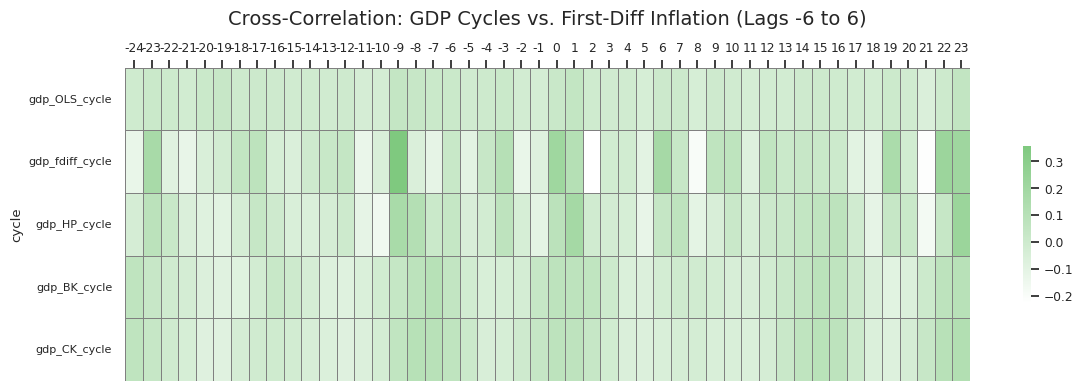


Summary Statistics per GDP Cycle:


,max_corr,min_corr,mean_corr
cycle,,,
gdp_OLS_cycle,0.051,-0.054,-0.003
gdp_fdiff_cycle,0.357,-0.224,0.002
gdp_HP_cycle,0.230,-0.169,-0.001
gdp_BK_cycle,0.104,-0.090,-0.002
gdp_CK_cycle,0.125,-0.082,-0.002


In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Parameters
reference = 'inflation_fdiff'
gdp_cycles = [
    'gdp_OLS_cycle',
    'gdp_fdiff_cycle',
    'gdp_HP_cycle',
    'gdp_BK_cycle',
    'gdp_CK_cycle'
]

flag = False

if flag:
    lags = range(-6, 7)
else:
    lags = range(-24, 24)

# Cross-correlation function
def lagged_corr(x, y, lag):
    if lag < 0:
        # GDP leads: shift GDP forward
        return x.shift(-lag).corr(y)
    elif lag > 0:
        # Inflation leads: shift inflation forward
        return x.corr(y.shift(lag))
    else:
        return x.corr(y)

# Compute correlation table
correlation_data = []
for cycle in gdp_cycles:
    row = [cycle]
    for lag in lags:
        corr = lagged_corr(DFC[cycle], DFC[reference], lag)
        row.append(corr)
    correlation_data.append(row)

columns = ['cycle'] + [f'{lag}' for lag in lags]
cross_corr_df = pd.DataFrame(correlation_data, columns=columns)

# Custom colormap: white → light green
min_corr = cross_corr_df.iloc[:, 1:].min().min()
max_corr = cross_corr_df.iloc[:, 1:].max().max()
green_map = LinearSegmentedColormap.from_list("white_to_green", ["white", "#7fc97f"])

# Plot
plt.figure(figsize=(12, 4))
sns.heatmap(
    cross_corr_df.set_index('cycle'),
    annot=flag,
    fmt=".3f",
    annot_kws={"fontsize": 8},           # Uniform font size for numbers
    cmap=green_map,
    vmin=min_corr,
    vmax=max_corr,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.5}
)

# Set font size for x and y ticks
plt.xticks(rotation=0, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Title
plt.title("Cross-Correlation: GDP Cycles vs. First-Diff Inflation (Lags -6 to 6)", fontsize=14, pad=12)

# Labels on top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.tight_layout()
plt.show()
# After plotting the heatmap...

# === Summary stats: max, min, mean correlation for each row ===
summary_stats = cross_corr_df.copy()
summary_stats.set_index('cycle', inplace=True)

# Compute statistics only on the correlation values (not the 'cycle' column)
summary = pd.DataFrame({
    'max_corr': summary_stats.max(axis=1),
    'min_corr': summary_stats.min(axis=1),
    'mean_corr': summary_stats.mean(axis=1)
})

# Format to 3 decimals
summary = summary.round(3)

# Display summary table
print("\nSummary Statistics per GDP Cycle:")
display(summary)


### Antigos

In [ ]:

# Compute required lags
dfa["pi_lead1"] = dfa["pi"].shift(-1)
dfa["pi_lead2"] = dfa["pi"].shift(-2)
dfa["pi_lead3"] = dfa["pi"].shift(-3)
dfa["pi_lead4"] = dfa["pi"].shift(-4)
dfa["pi_t"]   = dfa["pi"]
dfa["pi_lag1"] = dfa["pi"].shift(1)
dfa["pi_lag2"] = dfa["pi"].shift(2)
dfa["pi_lag3"] = dfa["pi"].shift(3)
dfa["pi_lag4"] = dfa["pi"].shift(4)

# Parameters
a1l = 0.24
a1i = 0.38
a4 = 0.12

# Apply formula
dfa["GDP_gap_calc"] = (1/a4)*(
    dfa["pi_t"] 
    - a1l * dfa["pi_lag1"] 
    - (a1i / 4) * (dfa["pi_lag1"] + dfa["pi_lag2"] + dfa["pi_lag3"] + dfa["pi_lag4"])
    - ((1-a1l-a1i)/4)*(dfa["pi_lead1"]+dfa["pi_lead2"]+ dfa["pi_lead3"]+ dfa["pi_lead4"])
    )

dfb = dfa.merge(df)

# Select columns ending with "_cycle"
cycle_columns = [col for col in dfb.columns if col.endswith("_cycle")]

# Drop all rows with any NaNs
dfc = dfb.dropna()

# Compute MSE for each cycle column
mse_results = {
    col: np.mean((dfc["GDP_gap_calc"] - dfc[col]) ** 2)
    for col in cycle_columns
}

# Convert to DataFrame and display
df_mse = pd.DataFrame.from_dict(mse_results, orient="index", columns=["MSE"])
df_mse = df_mse.sort_values("MSE")

display(df_mse)

,MSE
hp_cycle,0.005388
ck_cycle,0.005564
bk_cycle,0.005585
fdiff_cycle,0.005879
detrending_cycle,0.009767


In [ ]:
curve_selection_refs = plot_columns_selector(dfb)